## Modelling Stock Markets by Probabilistic 1-D Cellular Automata

The purpose of this section is to implement in Python the paper "Modelling Stock Markets by Probabilistic 1-D Cellular Automata" by Hakman A. Wan (1994).

##### References
- [The Nature of Code, Chapter 7: Cellular Automata](https://natureofcode.com/cellular-automata)
-  [Hakman A. Wan (1994) Modelling stock markets by probabilistic 1-D cellular automata, International Journal of Computer Mathematics, 53:3-4, 167-176, DOI: 10.1080/00207169408804323](https://www.tandfonline.com/doi/abs/10.1080/00207169408804323)
- [Simpelaere, D. Correlation Dimension. Journal of Statistical Physics 90, 491–509 (1998). https://doi.org/10.1023/A:1023232624745](https://link.springer.com/article/10.1023/A:1023232624745#citeas)


### Introduction

In the book "The Nature of Code", Daniel Shiffman defines a **cellular automaton** (CA) as:
> a model of a system of cell objects with the following characteristics:
>
> *   The cells live on a grid.
> *   Each cell has a state, though a cell’s state can vary over time. The number of possible states is typically finite. The simplest example has the two possibilities of 1 and 0 (otherwise referred to as on and off, or alive and dead).
> *   Each cell has a neighborhood. This can be defined in any number of ways, but it’s typically all the cells adjacent to that cell.

A more precise definition is the following: 

>A CA is a *n*-tuple `(U, X, Y, Q, S, N, Γ, Ω)` where:
>*   ***U*** is the set of discrete or cells, arranged linearly (in 1-D) or in a lattice (in 2-D or higher dimensions),
>*   ***X*** is the set of *input* symbols,
>*   ***Y*** is the set of *output* symbols,
>*   ***Q*** is the set of (internal) *states*,
>*   ***S*** is the initial state,
>*   ***N*** is the set of *neighbourhood* relations which determine the positions of the neighbouring cells relative to any given cell,
>*   **Γ** is a *transition function* which uses the current input received at a given cell together with the current neighbourhood state to determine the state *q* of this particular cell at the next time step, and
>*   **Ω** is the *output function* which acts on the entire lattice *U* to give a global output *O*.


Algorithms meant to simulate such systems have found several applications in the natural sciences, as well as in the social sciences. They've been used to simulate and study phenomena like: percolation, crystals solidfying, biological ecosystems.

The set of rules used to update the states of the cells on the grid may be either deterministic or stochastic, depending on $\Gamma$. In the paper we implement in the following section, the choice was to use a probabilistic CA, which allows for randomness in how the system evolves. The author made this choice because he deemed the use of deterministic rules contradictory to the unpredictabilty of a financial market. 



### Wolfram's Linear CA

To better illustrate, at a basic level, what a CA is, and how it works, we describe one of the simplest kind of systems of this kind: the linear and deterministic CA presented in S. Wolfram's "Statistical Mechanics of Cellular Automata" paper.

**Characteristics**
- This CA is a set $U$ of linearly arranged finite number of binary cells.
- If the set contains $n$ cells, each of the cells is identifiable by a number $i \in \{1,\dots, n\}$.
- The cells are binary because they can take either one of two binary values: 0 or 1. Hence, $Q$ here consists of $2^{n}$ states.
- The input signal is provided by some clock clik.
- This CA produces no output, and it evolves in accordance with how the neighbourhood function, and the transition function are defined. 
- The neighbourhood of any cell is a triple: the cell on the right, itself, and the cell on the left. 
- $S$, the initial configuration of the cells, is a given string of $n$ bits, e.g. $$0111100011001$$

**Transition Function**

$c(i,t): c: I \times Z \to \{0,1\}$ denotes the value of the cell $i$ at time $t$.

The transition function $\Gamma$ contains one rule; for instance 

$$c(i, t + 1) =
\begin{cases}
    0 & \text{if } c(i - 1, t)c(i, t)c(i + 1, t) \in \{111, 101, 010, 000\} \\
    1 & \text{otherwise}
\end{cases}$$

By applying this to the original configuration of cells defined above: 0111100011001, we get: $$0100110111110$$

*Note: there was a typo in the original paper, with the final digit being set to 1.*

In [1]:
initial_state_S = [0,1,1,1,1,0,0,0,1,1,0,0,1]
grid_length = len(initial_state_S)

updated_state = []

for cell_id in range(grid_length):

    prev_cell_id = None
    next_cell_id = None

    # Determine the left neighbouring cell, with looping boundaries
    if cell_id == 0:
        prev_cell_id = grid_length-1
    else:
        prev_cell_id = cell_id-1

    # Determine the right neighbouring cell, with looping boundaries
    if cell_id == grid_length-1:
        next_cell_id = 0
    else:
        next_cell_id = cell_id+1
    
    states_leading_to_0 = [[1,1,1],[1,0,1],[0,1,0],[0,0,0]]

    state_prev_cell = initial_state_S[prev_cell_id]
    state_current_cell = initial_state_S[cell_id]
    state_next_cell = initial_state_S[next_cell_id]

    cell_neighbourhood = [state_prev_cell, state_current_cell, state_next_cell]

    new_state = 0
    
    if cell_neighbourhood not in states_leading_to_0:
        new_state = 1
    
    updated_state.append(new_state)

print(f"The new state of the grid is {updated_state}")

The new state of the grid is [0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0]


### Modelling Financial Markets

In this section we implement the stock market models illustrated in the paper. 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from scipy.special import comb
from scipy.stats import linregress
from sklearn.preprocessing import StandardScaler

import pandas as pd
import seaborn as sns
from numba import jit

from statsmodels.graphics.tsaplots import plot_acf

### A Stock Market with a Single Kind of Stock - Markovian version

We start by presenting the simplest possible model one may think of when trying to use a CA to describe the behaviour of financial markets. 

**Assumptions**
- Constant number of traders who are interested in: buying, holding, and selling (3 possible states, constant number of active traders)
- One single stock in the market
- All traders are capable to buy, hold, or sell the same amount of stocks

**Implementation**

The stock market is considered to be a linear CA. Each cell represents a trader.
The state of trader $i$ at time $t$ is denoted as $c(i,t)$, using the same notation as Wolfram's model. 

*States*
- $c(i,t)=1$: the trader has the stock
- $c(i,t)=0$: the trader doesn't have the stock

*Transitions*
- From 1 (having the stock) to 0 (not having the stock) (Sale)
- From 0 (not having the stock) to 1 (having the stock) (Purchase)

Of course, if there is no transition it means that the seller is holding the stock. 

Just as Wolfram's example, the CA is finite, and with binary cells. 

The state of the CA at time $t$ can be measures as the sum of 1s in the cells, and it represents the number of stock holders. 
Mathematically speaking: $$Q = \{q(t):q(t)= \sum c(j,t), t=0,1,\dots\}=\{0,1,\dots,n\}$$

As a consequence, if $n$ is the number of traders in the market, then the cA can take any one of the $n+1$ possible states in $Q$.
$Q$, the current state of the market, may be regarded as an indicator of the popularity of a stock among the traders, or even the stock price itself. 

It's empirically evident that traders tend to follow what others are doing.
In this simplified model, the desire to buy or hold a stock will be proportional to the stock price. 

As a consequence, the probabilistic rule determining transitions is the following: $$Prob(c(i,t+1)=1)= \sum c(j,t)/n$$

In this model, differently from Wolfram's, the transition of a cell is affected by all cells in the CA (the entire grid is the neighbourhood for each cell), and the transition is probabilistic.

___
In the following section we show and describe the code we wrote to implement this basic model.  

In [2]:
class one_stock_markovian_financial_market:
    def __init__(self, n_investors, max_steps, initial_p_hold_stock):
        """
        Inputs:
        - n_investors = the number of investors in the simulated market (i.e. the number of cells)
        - max_steps = maximum number of steps that the simulation can run (as it may take long for convergence)
        - initial_p_hold_stock  = starting probability of holding stock to fill the grid at time 0
        """     
        self.n_investors = n_investors
        self.max_steps = max_steps

        self.p_hold_stock = initial_p_hold_stock

        # Stores the history of market states; i.e. the number of stock holders over time
        self.market_states = []
    
    def update_state(self):
        """
        Given the current market state, it returns the market array at the next step
        """
        p_hold_stock = self.market_states[-1] / self.n_investors  
       
        # Return scalar instead of array
        return np.random.binomial(self.n_investors, p_hold_stock)
        
    def run_simulation(self):
        """ 
        Stock market simulation runner
        """
        # Initialize market state
        self.market_states = []
        # Fill the grid at time 0
        current_market_state = np.random.binomial(self.n_investors, self.p_hold_stock)
        self.market_states.append(current_market_state)
        steps = 0

        # Perform the simulation
        ## Update the grid at each step
        ## Store the current state in the market_states list

        while (current_market_state != 0 and 
               current_market_state != self.n_investors and 
               steps < self.max_steps):
            
                current_market_state = self.update_state()
                self.market_states.append(current_market_state)
                steps += 1   

    def plot_results(self):
        """
        Plots the recorded market states (i.e. the number of stock holders) over time
        """


        plt.plot(self.market_states, label = "Market States")       
        plt.xlabel('Time Step')
        plt.ylabel('Number of Agents Holding Stock')
        plt.title('Market State Evolution')
        plt.grid(False)
        plt.legend()
        plt.show()

    def switch_state_probability_calc(self, i, j):
        """
        Calculate transition probability from state i to j        
        """
        
        # Validate states
        if i < 0 or i > self.n_investors or j < 0 or j > self.n_investors:
            return 0.0
        
        # Handle absorbing states
        if i == 0 or i == self.n_investors:
            return 1.0 if j == i else 0.0
        
        # Calculate transition probability
        p = i / self.n_investors
        return comb(self.n_investors, j) * (p ** j) * ((1 - p) ** (self.n_investors - j))
    
    def generate_transition_matrix(self, as_pandas_df=False, plot_heatmap=False, size_pic=(12, 10)):
        """ 
        Generates the matrix showing the transition probabilities between states of the market
        """
        matrix_size = self.n_investors + 1
        transition_matrix = np.zeros((matrix_size, matrix_size))
        
        # fill the matrix of transition probabilities
        for i in range(matrix_size):
            for j in range(matrix_size):
                transition_matrix[i, j] = self.switch_state_probability_calc(i, j)
        
        # convert the matrix to a pandas dataframe (if enabled)
        if as_pandas_df:
            states = [f'S{i}' for i in range(matrix_size)]
            df = pd.DataFrame(transition_matrix, index=states, columns=states)
            
            if plot_heatmap:
                plt.figure(figsize=size_pic)
                sns.heatmap(
                    df, 
                    annot=True, 
                    fmt=".2f", 
                    cmap="viridis",
                    cbar_kws={'label': 'Transition Probability'}
                )
                plt.title('Markov Transition Matrix')
                plt.show()
            return df
        
        return transition_matrix
    
    def absorption_time(self, print_flag=True):
        """
        Calculate theoretical absorption time using paper's formula        
        """
        S = self.p_hold_stock 
        
        if S <= 0 or S >= 1:
            if print_flag:
                print("Initial market share must be between 0 and 1 (exclusive)")
            return 0.0

        abs_time = -2 * (S * np.log(S) + (1 - S) * np.log(1 - S))
        
        if print_flag:
            print(f"Theoretical absorption time: {abs_time:.4f} (continuous time units)")
            print(f"Estimated discrete steps: {abs_time * self.n_investors:.1f}")
        
        return abs_time

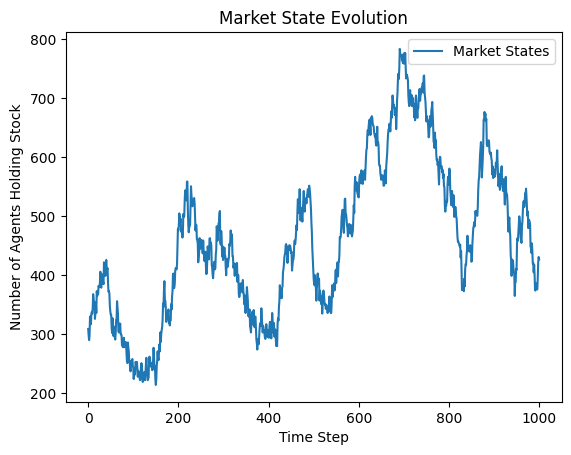

In [4]:
CA_markovian_basic = one_stock_markovian_financial_market(n_investors= 1000, max_steps= 1000, initial_p_hold_stock= 0.3)
CA_markovian_basic.run_simulation()
CA_markovian_basic.plot_results()

**Features of the Model**

*Markov Property*
The model is Markovian because the transition of the CA at time $t$ depends on the state of the CA at time $t$, not on the previous states, even if they are known.  $$Prob(q(t)|q(i):i<t)=Prob(q(t)|q(t-1))$$

The evolution is therefore a Markov chain.
This assumption is plausible, as, in real life, although the current stock price influences the stock price in the future, the influence is not decisive, and if the current stock price is used to forecast future prices, its effect grows weaker, as time goes by.

*Mathematical Description of the transition probabilities of the Markov Chain*

We can describe $p_{ij}$, the probability that state $i$ is changed to state $j$ in one time lag, in the following way: $$p_{ij}= {n \choose j} \left(\frac{i}{n} \right)^{j} \left(1- \frac{i}{n} \right)^{n-j}$$

Recall that $i$ simply represents the number of current stock holders. So it's simply a binomial probability where $p=\frac{i}{n}$, which is how we've defined the probability that a single trader will decide to hold a stock.

Of course, using elementary math, we can conclude that the probability to change from state $i$ to any state higher than $j*$ is given by: 
$$
p_{ij^*} + p_{i(j^*+1)} + \dots + p_{in} \equiv \sum_{j=j^*}^n p_{ij}
$$

If $p_{ij}^{(2)}$ represents the probability that state $i$ is changed to state $j$ in two time lags, of course, we have that: 

$$
p_{ij}^{(2)} = \sum_{k=1}^{n} p_{ik}p_{kj}
$$

This can be generalized to multiple time lags in the following way: 

$$
p_{ij}^{(m+1)} = \sum_{k=1}^{n} p_{ik} p_{kj}^{(m)} \quad (6)
$$

$$
p_{ij}^{(m_1+m_2)} = \sum_{k=1}^{n} p_{ik}^{(m_1)} p_{kj}^{(m_2)} \quad (7)
$$

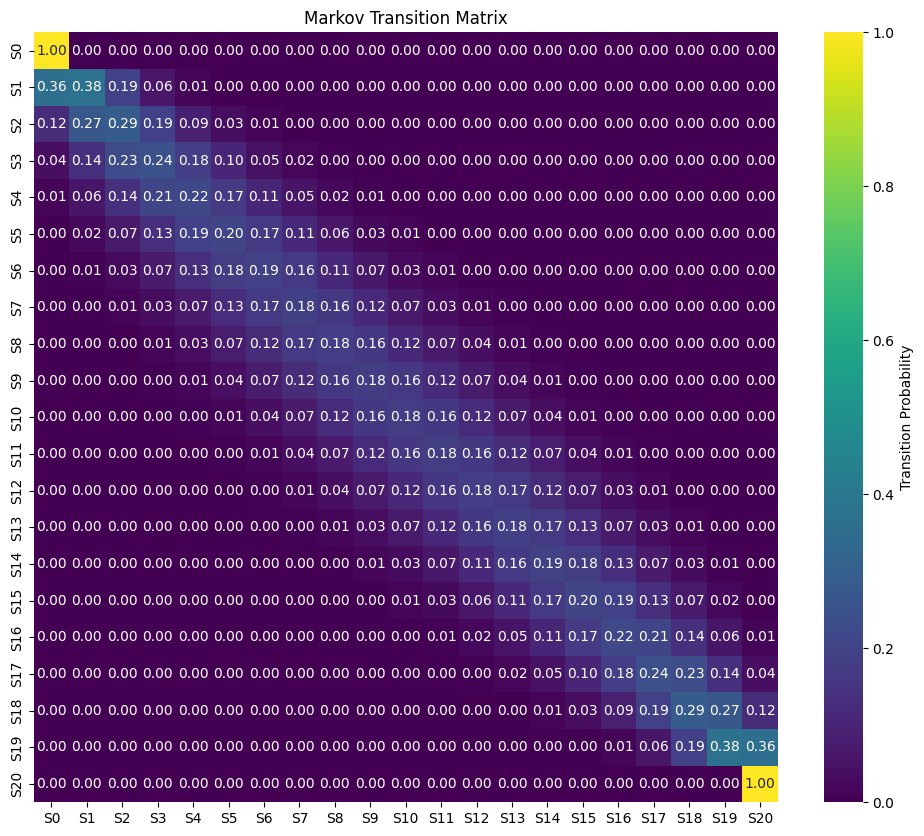

,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S11,S12,S13,S14,S15,S16,S17,S18,S19,S20
S0,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
S1,3.584859e-01,3.773536e-01,1.886768e-01,5.958215e-02,1.332759e-02,2.244646e-03,2.953482e-04,3.108928e-05,2.658952e-06,1.865931e-07,...,5.168784e-10,2.040309e-11,6.608289e-13,1.739024e-14,3.661102e-16,6.021550e-18,7.457027e-20,6.541252e-22,3.623962e-24,9.536743e-27
S2,1.215767e-01,2.701703e-01,2.851798e-01,1.901199e-01,8.977883e-02,3.192136e-02,8.867045e-03,1.970454e-03,3.557765e-04,5.270763e-05,...,6.507115e-07,5.422595e-08,3.707758e-09,2.059865e-10,9.154957e-12,3.178805e-13,8.310600e-15,1.539000e-16,1.800000e-18,1.000000e-20
S3,3.875953e-02,1.367983e-01,2.293384e-01,2.428289e-01,1.821217e-01,1.028452e-01,4.537287e-02,1.601396e-02,4.592237e-03,1.080526e-03,...,3.364961e-05,4.453625e-06,4.836516e-07,4.267514e-08,3.012363e-09,1.661229e-10,6.897839e-12,2.028776e-13,3.768624e-15,3.325257e-17
S4,1.152922e-02,5.764608e-02,1.369094e-01,2.053641e-01,2.181994e-01,1.745595e-01,1.090997e-01,5.454985e-02,2.216088e-02,7.386959e-03,...,4.616849e-04,8.656592e-05,1.331783e-05,1.664729e-06,1.664729e-07,1.300570e-08,7.650410e-10,3.187671e-11,8.388608e-13,1.048576e-14
S5,3.171212e-03,2.114141e-02,6.694781e-02,1.338956e-01,1.896855e-01,2.023312e-01,1.686093e-01,1.124062e-01,6.088669e-02,2.706075e-02,...,3.006750e-03,7.516875e-04,1.541923e-04,2.569872e-05,3.426496e-06,3.569266e-07,2.799425e-08,1.555236e-09,5.456968e-11,9.094947e-13
S6,7.979227e-04,6.839337e-03,2.784587e-02,7.160367e-02,1.304210e-01,1.788631e-01,1.916390e-01,1.642620e-01,1.143967e-01,6.536957e-02,...,1.200665e-02,3.859282e-03,1.017833e-03,2.181070e-04,3.738977e-05,5.007558e-06,5.049639e-07,3.606885e-08,1.627166e-09,3.486784e-11
S7,1.812455e-04,1.951874e-03,9.984587e-03,3.225790e-02,7.382096e-02,1.271992e-01,1.712297e-01,1.844012e-01,1.613510e-01,1.158418e-01,...,3.358726e-02,1.356409e-02,4.494608e-03,1.210087e-03,2.606341e-04,4.385670e-05,5.556505e-06,4.986607e-07,2.826417e-08,7.609584e-10
S8,3.656158e-05,4.874878e-04,3.087423e-03,1.234969e-02,3.499079e-02,7.464702e-02,1.244117e-01,1.658823e-01,1.797058e-01,1.597385e-01,...,7.099488e-02,3.549744e-02,1.456305e-02,4.854351e-03,1.294494e-03,2.696862e-04,4.230371e-05,4.700412e-06,3.298535e-07,1.099512e-08
S9,6.415844e-06,1.049865e-04,8.160317e-04,4.005974e-03,1.392986e-02,3.647092e-02,7.459960e-02,1.220721e-01,1.623004e-01,1.770550e-01,...,1.185244e-01,7.273087e-02,3.661974e-02,1.498080e-02,4.902808e-03,1.253559e-03,2.413269e-04,3.290821e-05,2.834200e-06,1.159445e-07


In [5]:
# For the sake of readability and practicality, we define a new, much smaller, market 
# Then we plot the states transition matrix

transition_matrix_market = one_stock_markovian_financial_market(n_investors= 20, max_steps= 100,
                                                               initial_p_hold_stock= 0.5)

transition_matrix_market.generate_transition_matrix(as_pandas_df= True, plot_heatmap= True)

**Introduction to the Notion of Absorption Time**

The fact that in our simulations there is the chance that a stock can win overwhelmingly all the traders in a stock market is rather irrealistic. However, this is a consequence that the CA is assumed finite.

Indeed, a finite Markovian process will inevitably end up in a homogeneous state.

In this toy model it may be interesting to know how long it takes for a stock to become the sole winner of the market or be uprooted from it. This quantity we want to estimate is the *absorption time* of the stock. 

Here is how we can derive the formula for it:

**Absorption Time Formula Derivation**

Let $T(S)$ be the average time (in time lags) for absorption to occur, i.e.

$$
T(S) = E \left[\tau(S)\right]
$$

where $\tau$ is the absorption time dependent on a particular initial state S (the market share of the stock at time $t=0, S \in [0, 1]$), i.e.

$$
\tau(S) = \inf\{t \ge 0 | q(0) = S, q(t) = 0 \text{ or } q(t) = 1\}
$$

where $q$ is the state of the market, and $u$ is the number of cells.

The core idea of the derivation is that we can express thee xpected time to absorption from state $S$ as: $$T(S) = \delta t + E[T(q(\delta t))]$$

Where $q(\delta t)$ is the new state after a small time step $\delta t$.

Assume that $T$ is twice continuously differentiable, then we can use a Taylor series expansion, take the expectation on both sides, and get the following result:

$$
E[T(q(\delta t))] = T(S) + (E\left[q(\delta t)- S\right] )\frac{d}{dS}T(S) + \frac{1}{2}E\left[(q(\delta t) - S)^2\right] \frac{d^2}{dS^2}T(S) + \text{higher terms}
$$


Note that the higher terms $\to 0$ as $\delta t \to 0$. Then, after substituting our expanded result into the original equation ($T(S) = \delta t + E[T(q(\delta t))]$), we first see that the $T(S)$ terms cancel out. 

Then we move $\delta t$ to the other side and divide the whole equation by $\delta t$. In this way, we get:

$$
-1 = \frac{E\left[q(\delta t) - S\right]}{\delta t} \frac{d}{dS}T(S) + \frac{1}{2}\frac{E\left[(q(\delta t) - S)^2\right]}{\delta t} \frac{d^2}{dS^2}T(S)
$$

Take limit as $\delta t \to 0$:

$$
-1 = a(S)\frac{d}{dS}T(S) + \frac{1}{2}b(S)\frac{d^2}{dS^2}T(S)
$$

where
$$
a(S) = \lim_{\delta t \to 0} \frac{E[q(\delta t) - S]}{\delta t}
$$

and
$$
b(S) = \lim_{\delta t \to 0} \frac{E[(q(\delta t) - S)^2]}{\delta t}
$$

It's straightforward to notice that $a(S)$ and $b(S)$ may be seen as the drift and diffusion coefficient of a SDE.

Since the process is Markovian, $E[q(\delta t)] = S$ and $Var(q(\delta t)) = E(q(\delta t) - S)^2 = S(1-S)/n$, then
$$
a(S) = 0
$$

In other words, our process is a martingale, and

$$
b(S) = \frac{S(1-S)}{\delta t n}
$$

Take $\delta t = 1/n$. Then for $n \to \infty$, we get
$$
-1 = \frac{1}{2}S(1-S)\frac{d^2T}{dS^2}
$$

with boundary conditions $T(0) = T(1) = 0$. 

Its solution is
$$
T(S) = -2[S \ln S + (1-S) \ln(1-S)]
$$

Hence the average absorption time depends solely on the initial condition of the CA.

The solution was simply achieved by isolating the differential operator on the right-hand side,  integrating twice the left-hand side, and then applying the boundary conditions. 

**NOTE**

Compared to the derivation of the original paper, here we made adjustments to fix some typos and make the notation clearer.


In [6]:
# Here is the absorption time calculation for the original model with 1000 investors
CA_markovian_basic.absorption_time()

Theoretical absorption time: 1.2217 (continuous time units)
Estimated discrete steps: 1221.7


1.221728604109787

### A Stock Market with a Single Kind of Stock - Non-Markovian version

In this section, we drop the constraint of having a Markovian market. Now, traders will be able to take the history of stock prices into consideration, rather than merely relying on the stock price of the previous time step.

The new expression we use to determine the evolution of cell states in this model is: 
$$
\text{Prob}(c(i, t) = 1) = \frac{1}{n} \sum_{k=1}^{m} a_k \sum_{j=1}^{n} c(j, t - k)
$$

Where $m$ is the length of retrospection and $a_{k}$'s are some constant real numbers such that $\sum a_{k}=1$.

For instance, if we considered at most the stock prices of two consecutive days, the function determining the probability of holding the stock in a certain state would be given by: 
$$
\text{Prob}(c(i, t) = 1) = \alpha \sum c(j, t - 1)/n + (1 - \alpha) \sum c(j, t - 2)/n
$$

In [14]:
class one_stock_financial_market(one_stock_markovian_financial_market):
    def __init__(self, n_investors, max_steps, initial_p_hold_stock):
        super().__init__(n_investors, max_steps, initial_p_hold_stock)
    
    def update_state(self, markovian, past_info_w = None):
    
        if not markovian:
            # determine how many past observations to consider
            # used when we have fewer observations than the number of trading days we consider
            past_observations_considered = min(len(self.market_states), len(past_info_w))
            
            # clip the weight vector length to prevent array size issues when there aren't enough obs
            weights = np.array(past_info_w[-past_observations_considered:])
            
            # normalize the weights of the vector
            if np.sum(weights) == 0:
                # In this way we control for the case in which we don't want traders to consider recent info
                # as this can lead to division by 0
                # while we have insufficient information, we assume uniform probability given to prev info
                weights = np.ones(past_observations_considered)/past_observations_considered
            else:
                weights = weights/np.sum(weights)
            
            market_states = np.array(self.market_states)
            previous_trans_prob = (market_states/self.n_investors)[-past_observations_considered:]
            
            # compute the new probability of holding the stock as a dot product
            p_hold_stock = np.dot(previous_trans_prob, weights)
        else:
            # Markovian: only current state matters
            p_hold_stock = self.market_states[-1]/self.n_investors
        
        # Clip probability to valid range [0, 1]
        p_hold_stock = np.clip(p_hold_stock, 0.0, 1.0)
        
        # Return scalar instead of array
        return np.random.binomial(self.n_investors, p_hold_stock)
    
    def run_simulation(self, markovian=True, past_info_w = None):
        
        # Input validation to check that the past_info_w weights sum to one and are present if non-markovian
        # round introduced to prevent numerical stability issues
        if markovian == False:
            assert np.round(np.sum(past_info_w),10) == 1
        
        # Initialize market state
        self.market_states = []
         # Fill the grid at time 0
        current_market_state = np.random.binomial(self.n_investors, self.p_hold_stock)

        self.market_states.append(current_market_state)

        steps = 0
        
        while (current_market_state != 0 and 
               current_market_state != self.n_investors and 
               steps < self.max_steps):
            
            if markovian:
                # Markovian update
                current_market_state = self.update_state(markovian)
        
            # For non-Markovian: use previous states according to the length of the weights array
            else:
                current_market_state = self.update_state(
                    markovian=False,
                    past_info_w=past_info_w                     
                    )
            
            self.market_states.append(current_market_state)
            steps += 1

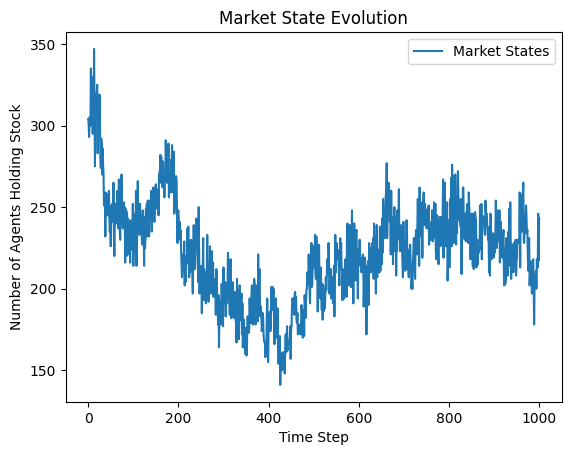

In [28]:
CA_non_markovian = one_stock_financial_market(n_investors= 1000, max_steps= 1000,
                                              initial_p_hold_stock= 0.3
                                              )

# as we increase the number of days considered, the series becomes more stationary
n = 5
past_info_weight_matrix = np.ones(n)/n

CA_non_markovian.run_simulation(past_info_w= past_info_weight_matrix, markovian= False)
CA_non_markovian.plot_results()

#### Finding the Correlation Dimension

In this section we calculate the correlation dimension of the time series generated by the the CA. The correlation dimension is a fractal dimension that measures the complexity of a time series, in particular in the context of chaotic dynamical systems. 

It quantifies the number of degrees of freedom in a system by determining how the number of "close" points in the reconstructed phase space scales with the radius of the sphere. 

In particular, a simple, non-chaotic system will have an integer dimension. A low-dimensional chaotic system will have a non-integer dimension. For random or stochastic data, the correlation dimension will increase without limit as the embedding dimension increases, as every new dimension adds an independent degree of freedom. On the contrary, for chaotic systems the dimension will saturate at a finite value as the embedding dimension increases. 

More precisely, we implement the following procedure described in the paper: 

**Procedure** 

Several time series $q(i)$ are first recorded from the evolution of the model. 

An embedding dimension $d$ is chosen to divide the time series into a sequence of vectors $\{Q(i)\}$, where $Q(i) = [q(i), q(i + 1), \dots, q(i + d - 1)]^T$. The values of $C_c(i, t)$ are recorded as a time series in each trial. The values of $\log(r)$ are plotted against those of $\log(C_n(r))$, where $C_n$ is defined as

$$
C_n(r) = \frac{\{\text{number of pairs } (Q(i), Q(j)) \mid i \neq j \text{ and } \|Q(i) - Q(j)\| < r\}}{n^2} 
$$

and $r$ is an arbitrary small number. The correlation dimensions of the time series are found as the tangent of the linear region of the graph. 

In [127]:
@jit
def compute_correlation_integral_count(time_series, embedding_dimension, r):
    N = len(time_series)

    if N < embedding_dimension:
         return 0

    num_vectors = N-embedding_dimension+1
    embedded_vectors = np.zeros((num_vectors, embedding_dimension))

    # slice the time series and store the slices in an array
    for i in range(num_vectors):
        embedded_vectors[i] = time_series[i : i + embedding_dimension]
    
    pair_count = 0

    # compute the euclidean distance between slices
    for i in range(num_vectors):
        for j in range(i+1, num_vectors):
            distance = np.linalg.norm(embedded_vectors[i]-embedded_vectors[j])
            # count when the euclidean distance is lower than the radius
            if distance < r:
                pair_count += 1
    
    return pair_count      

@jit
def compute_Cn_r(time_series, embedding_dimension, r):
    # we multiply by 2 as we only work with an upper triangular matrix when performing the original computations
    numerator = 2*compute_correlation_integral_count(time_series, embedding_dimension, r)
    
    num_vectors = len(time_series)-embedding_dimension+1
    # renormalize by the number of vectors squared
    denominator = num_vectors**2

    Cn_r = numerator/denominator

    return Cn_r

In [185]:
CA_corr_dimension_simulator = one_stock_financial_market(n_investors= 10000, max_steps= 1000,
                                              initial_p_hold_stock= 0.5
                                              )
CA_corr_dimension_simulator.run_simulation(markovian= False, past_info_w= [0.3,0.7])

historical_market_share = np.array(CA_corr_dimension_simulator.market_states)/CA_corr_dimension_simulator.n_investors

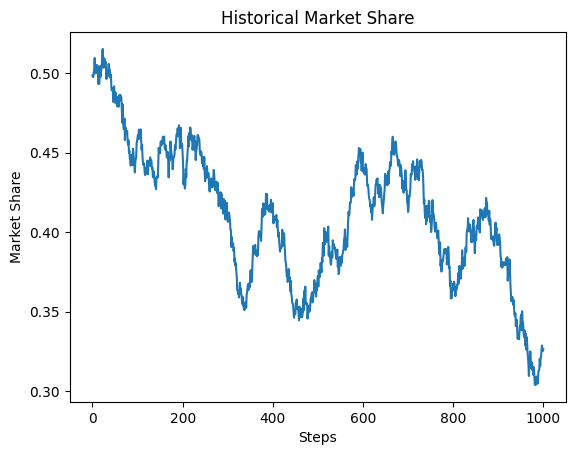

In [186]:
plt.title("Historical Market Share")
plt.plot(historical_market_share);

plt.xlabel("Steps");
plt.ylabel("Market Share");

In [187]:
def compute_Cn_values(embedding_dimension_values, r_values, time_series):    
    log_Cn_values = {}
    # compute Cn_r for each combination of embedding dimension and radius
    for d in embedding_dimension_values:
        # for each embedding dimension, store the values of Cn in a dictionary
        log_Cn_values[d] = []
        for r in r_values:
            Cn = compute_Cn_r(time_series, d, r)
            ### append valid log-values for Cn, where the log is not -infinity
            if Cn > 0:
                log_Cn_values[d].append(np.log(Cn))
            else: 
                log_Cn_values[d].append(np.nan)
    return log_Cn_values

def find_correlation_dimension_automated(log_r, log_Cn, window_size = 15):
    """ 
    Finds automatically the tangent of the linear region in the graph based on the segment in which 
    the R^2 is maximized.
    """

    best_r_squared = -1.0
    best_slope = None

    for i in range(len(log_r) - window_size + 1):
        start_index = i
        end_index = i + window_size
        
        window_x = log_r[start_index:end_index]
        window_y = log_Cn[start_index:end_index]

        result = linregress(window_x, window_y)
        
        if result.rvalue**2 > best_r_squared:
            best_r_squared = result.rvalue**2
            best_slope = result.slope

    return best_slope

In [188]:
embedding_dimension_values = np.linspace(2,20,19, dtype= int)
r_values = np.logspace(np.log10(0.01), np.log10(0.5), 30)
log_r_values = np.log(r_values)

Cn_values_dict = compute_Cn_values(embedding_dimension_values= embedding_dimension_values, 
                                   r_values= r_values, 
                                   time_series= historical_market_share)

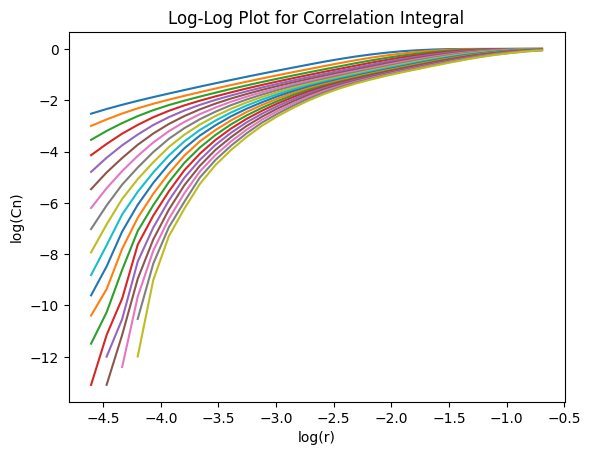

In [191]:
for d in embedding_dimension_values:
    valid_indices = ~np.isnan(Cn_values_dict[d])
    log_r_plot = np.array(log_r_values)[valid_indices]
    log_Cn_plot = np.array(Cn_values_dict[d])[valid_indices]
    plt.plot(log_r_plot, log_Cn_plot, label=f"d = {d}")

plt.xlabel("log(r)")
plt.ylabel("log(Cn)")
plt.title("Log-Log Plot for Correlation Integral")
plt.show()

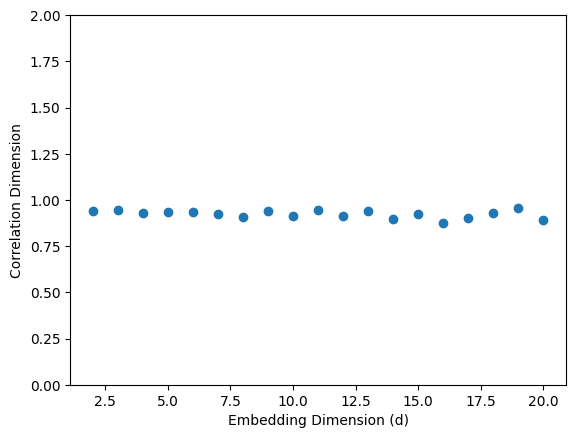

In [195]:
slopes = []

for d in embedding_dimension_values:
    slopes.append(find_correlation_dimension_automated(log_r_values, Cn_values_dict[d], window_size= 15))

# Results Plotting
plt.scatter(embedding_dimension_values, slopes);
plt.xlabel("Embedding Dimension (d)");
plt.ylabel("Correlation Dimension");
plt.ylim((0,2));

### A Stock Market with a Single Kind of Stock - Asyncronous Version (Big and Small Traders)

In this section we implement an extension of the original Markovian model, whereby the transition is assumed to be asynchronous. In this particular case, indeed, we include two kinds of traders in the market: big and small traders.

We have $n_{1}$ big traders who make their move first, and $n_{2}=n-n_{1}$ small traders that tend to follow what the big traders do.

 The transition probability function for the big traders ($i₁ = 1,..., n₁$) is
$$
\text{Prob}(c(i_1, t) = 1) = \sum c(j, t - 1)/n 
$$
and that for small traders ($i₂ = 1,..., n₂$) is
$$
\text{Prob}(c(i_2, t) = 1) = \alpha \sum c(i_1, t)/n_1 + (1 - \alpha) \sum c(j, t - 1)/n 
$$
where $0 < α < 1$. The CA seems to absorb at a faster rate than the previous models. 


In [197]:
class one_stock_asyncronous_model(one_stock_financial_market):
    def __init__(self, n_investors, max_steps, initial_p_hold_stock):
        super().__init__(n_investors, max_steps, initial_p_hold_stock)

        # stores the big trader states over time
        self.big_trader_states = []
    
    def update_state_big_small(self, big_traders_num, alpha, small_trader = False):
        n_investors = self.n_investors
        current_market_state = self.market_states[-1]
        big_traders_state = self.big_trader_states[-1]
        
        if small_trader == True:
            n_investors = n_investors - big_traders_num
            p_hold_stock = (1-alpha)*(current_market_state / self.n_investors)+alpha*(big_traders_state/big_traders_num)

        else:
            n_investors = big_traders_num
            p_hold_stock = current_market_state / self.n_investors  
        
        # Clip probability to valid range [0, 1]
        p_hold_stock = np.clip(p_hold_stock, 0.0, 1.0)
        
        return np.random.binomial(n_investors, p_hold_stock)

    def run_two_type_traders_model(self, percentage_big_traders = 0.2, alpha = 0.3):

        self.market_states = []
        self.big_trader_states = []

        steps = 0

        alpha = np.clip(alpha, 0.0, 1.0)
        p_big_traders = np.clip(percentage_big_traders, 0.0, 1.0)

        # determine the number of big and small traders
        n_big_traders = np.round(p_big_traders*self.n_investors,0)
        n_small_traders = self.n_investors - n_big_traders

        # determine the initial market state for both big and small traders, and as a whole
        current_market_state_big = np.random.binomial(n_big_traders, self.p_hold_stock)
        current_market_state_small = np.random.binomial(n_small_traders, self.p_hold_stock)        
        current_market_state_total = current_market_state_big + current_market_state_small

        # update market state time series
        self.market_states.append(current_market_state_total)
        self.big_trader_states.append(current_market_state_big)

        while (current_market_state_total != 0 and 
            current_market_state_total != self.n_investors and 
            steps < self.max_steps):     


            current_market_state_big = self.update_state_big_small(
                n_big_traders,
                alpha = alpha,
            )      

            current_market_state_small = self.update_state_big_small(
                n_big_traders,
                alpha = alpha,
                small_trader= True
            )           
            
            current_market_state_total = current_market_state_small+current_market_state_big
            
            # update market state time series
            self.market_states.append(current_market_state_total)
            self.big_trader_states.append(current_market_state_big)
            
            steps += 1 
    
    def plot_results(self):
        plt.plot(self.market_states, label = "Market States", alpha = 0.5)
        plt.plot(self.big_trader_states, label = "Market States (Big Traders)")
        small_trader_states = np.array(self.market_states)-np.array(self.big_trader_states)            
        plt.plot(small_trader_states, label = "Market States (Small Traders)")
       
        plt.xlabel('Time Step')
        plt.ylabel('Number of Agents Holding Stock')
        plt.title('Market State Evolution')
        plt.grid(False)
        plt.legend()
        plt.show()

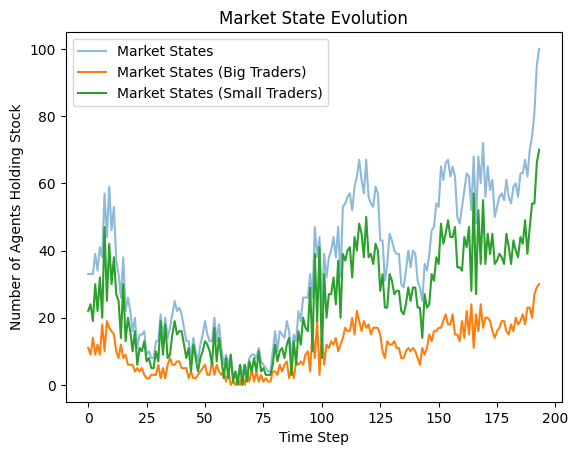

In [214]:
two_traders_model = one_stock_asyncronous_model(n_investors= 100,
                                                max_steps= 1000,
                                                initial_p_hold_stock= 0.3)

two_traders_model.run_two_type_traders_model(percentage_big_traders= 0.3,
                                             alpha = 0.9)

two_traders_model.plot_results()

### A Stock Market with Two Kinds of Stock 

In this section, we implement the final model presented in Wan's paper: the model with two stocks. 

Given the lack of sufficiently detailed information provided by the author, we propose two different possible implementations. 

In this model we have two different kinds of stock: $A$ and $B$. 
If cells of the CA model still represent traders, there are at least three different states for the cells: 
* $-1$ (holding stock A)
* $0$ (holding nothing)
* $1$ (holding stock B)

The current prices (i.e. the proportions of traders) of both stock exert positive and engative influences on the decisions of the traders.

In this model, the probability that a trader is willing to stick to the stock he/she is having is
$$
\text{Prob}(c(i, t) = A) = \alpha N_A + \beta N_B 
$$

where $N_A$ and $N_B$ are respectively the proportions of traders that holds stock $A$ and stock $B$ at $t-1$, the evolution of the market model can be simulated by the CA. 

In [ ]:
# First version of the two stocks model
# In this version we determine sequentially the number of stock holders, then the number of A holders#
# and by exclusion the number of B holders

class two_stocks_model_v1(one_stock_financial_market):
    def __init__(self, n_investors, max_steps, initial_p_hold_stock):
        super().__init__(n_investors, max_steps, initial_p_hold_stock)

        # lists to store the time series of the states of stock A and B
        self.stock_A_market_state = []
        self.stock_B_market_state = []
    

    def update_two_stocks(self, current_total_holders, alpha, beta):        
        prev_stock_A_holders = self.stock_A_market_state[-1]
        prev_total_holders = self.market_states[-1]
        
        N_A = prev_stock_A_holders / prev_total_holders if prev_total_holders > 0 else 0
        N_B = (prev_total_holders - prev_stock_A_holders) / prev_total_holders if prev_total_holders > 0 else 0

        p_hold_A = alpha * N_A + beta * N_B
        p_hold_A = np.clip(p_hold_A, 0.0, 1.0)    

        return np.random.binomial(current_total_holders, p_hold_A)

    # helper function to make the code less clutered when updating the 3 time series lists
    def record_state_two_stocks(self, current_total_holders, stock_A_n, stock_B_n):
        self.market_states.append(current_total_holders)
        self.stock_A_market_state.append(stock_A_n)
        self.stock_B_market_state.append(stock_B_n)
    
    def run_two_stocks_model_V1(self, init_prob_hold_A = 0.5, alpha = 1, beta = 0.05, only_A_B_decision = False, stochastic_start = False):
        
        self.market_states = []
        self.stock_A_market_state = []
        self.stock_B_market_state = []
        
        # if there is only the decision between stocks A and B we won't have any non-stock-holders in the market
        if only_A_B_decision == True:
            current_total_holders = self.n_investors
            current_stock_A = np.random.binomial(current_total_holders, init_prob_hold_A)
        else:
            # if we also consider non-holders, we may decide randomly the number of holders, or set it manually
            if stochastic_start == True:
                current_total_holders = np.random.binomial(self.n_investors, self.p_hold_stock)
                current_stock_A = np.random.binomial(current_total_holders, init_prob_hold_A)
            else:
                current_total_holders = int(self.n_investors*self.p_hold_stock)
                current_stock_A = int(current_total_holders * init_prob_hold_A)                     
        
        current_stock_B = current_total_holders - current_stock_A        

        self.record_state_two_stocks(current_total_holders, current_stock_A, current_stock_B)
        
        steps = 0

        while (current_total_holders != 0 and 
               current_stock_A != self.n_investors and current_stock_B != self.n_investors and 
               steps < self.max_steps):  

                # first we determine the current number of stock holders, in general
                # the rule to determine such number is the same used in the markovian model
                current_total_holders = self.update_state(
                    markovian=True
                )

                # once we have the number of holders, among those we determine the number of stock A holders
                current_stock_A = self.update_two_stocks(
                    current_total_holders,
                    alpha,
                    beta
                )
                
                # by exclusion we determine the number of stock B holders
                current_stock_B = current_total_holders - current_stock_A

                self.record_state_two_stocks(current_total_holders, current_stock_A, current_stock_B)

                steps += 1 
    
    def plot_two_stocks_results(self, non_holders = False):

        # based on whether non_holders is flagged we may or may not plot the number of non-stock-holders
        if non_holders == True:
            non_holders = np.array(self.stock_A_market_state)-np.array(self.stock_B_market_state)
            plt.plot(non_holders, label="Non Stock Holders", color='green', alpha = 0.3)

        plt.figure(figsize=(10, 6))
        plt.plot(self.market_states, label="Total Stock Holders", color='black', linestyle='--')
        plt.plot(self.stock_A_market_state, label="Stock A Holders", color='blue')
        plt.plot(self.stock_B_market_state, label="Stock B Holders", color='red')        

        plt.xlabel('Time Step')
        plt.ylabel('Number of Investors')
        plt.title('Two Stocks Market State Evolution')
        plt.legend()
        plt.show()

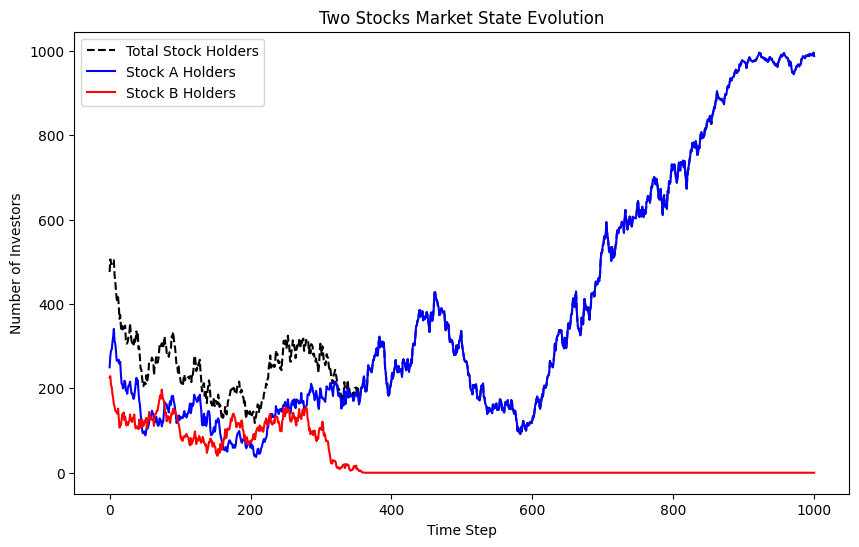

In [300]:
two_stocks_sim_v1 = two_stocks_model_v1(n_investors= 1000,
                                        max_steps= 1000,
                                        initial_p_hold_stock= 0.5)

two_stocks_sim_v1.run_two_stocks_model_V1(init_prob_hold_A= 0.5,
                                          alpha= 1,
                                          beta = 0,
                                          only_A_B_decision= False,
                                          stochastic_start= True)

two_stocks_sim_v1.plot_two_stocks_results()

In [323]:
# Second version of the two stocks model

# In this version, we use the choice function to determine in the same step A,B holders and non-holders
# We also allow for different probability parameters for A and B stocks, extending the original model

class two_stocks_model_v2(two_stocks_model_v1):
    def __init__(self, n_investors, max_steps, initial_p_hold_stock):
        super().__init__(n_investors, max_steps, initial_p_hold_stock)

    def count_holders_V2(self, current_market_state):
        A_holders = np.sum(current_market_state == -1)
        N_holders = np.sum(current_market_state == 0)
        B_holders = np.sum(current_market_state == 1)

        return [A_holders, N_holders, B_holders]
    
    def update_two_stocks_V2(self, params_A_alpha_beta, params_B_gamma_delta):
        # Compute the proportions of stock A and B holders
        N_A = self.stock_A_market_state[-1]/self.n_investors
        N_B = self.stock_B_market_state[-1]/self.n_investors

        alpha, beta = params_A_alpha_beta
        gamma, delta  = params_B_gamma_delta

        # compute the transition probabilities
        p_A = alpha * N_A + beta * N_B
        p_B = gamma * N_B + delta * N_A

        # ensure that they are probabilities
        p_A = np.clip(p_A, 0, 1)
        p_B = np.clip(p_B, 0,1)

        p_N = np.clip(1-p_A - p_B,0,1)

        # renormalize the probabilities
        p_total = p_A+p_B+p_N
        p_A /= p_total
        p_B /= p_total
        p_N /= p_total

        # determine the new market state
        new_state = np.random.choice(
                                [-1, 0, 1], 
                                size=self.n_investors,
                                p=[p_A, p_N, p_B]
                            )
        return new_state

    def run_two_stocks_models_v2(self, init_probs_A_N_B: list, params_A_alpha_beta = [1,0.05], params_B_gamma_delta = [1,0.05]):

            self.market_states = []
            self.stock_A_market_state = []
            self.stock_B_market_state = []

            if np.sum(init_probs_A_N_B) != 1:
                print("Initial probabilities should sum to 1!")
                return 0
            
            init_prob_A = init_probs_A_N_B[0]
            init_prob_N = init_probs_A_N_B[1]
            init_prob_B = init_probs_A_N_B[2]
            
            current_market_state =  np.random.choice(
                                    [-1, 0, 1], 
                                    size=self.n_investors,
                                    p=[init_prob_A, init_prob_N, init_prob_B]
                                )
            
            A_holders, N_holders, B_holders = self.count_holders_V2(current_market_state)
            self.record_state_two_stocks(np.sum([A_holders, B_holders]), A_holders, B_holders)
            
            steps = 0

            while (N_holders != self.n_investors and A_holders != self.n_investors and B_holders != self.n_investors
                and steps < self.max_steps):
                
                new_market_state = self.update_two_stocks_V2(params_A_alpha_beta,params_B_gamma_delta)
                A_holders, N_holders, B_holders = self.count_holders_V2(new_market_state)
                self.record_state_two_stocks(np.sum([A_holders, B_holders]), A_holders, B_holders)

                steps += 1

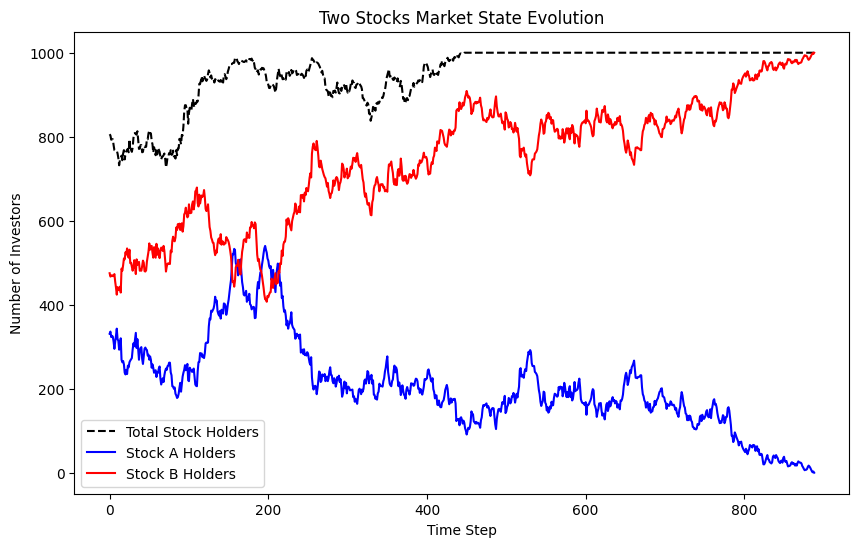

In [327]:
two_stocks_sim_v2 = two_stocks_model_v2(n_investors= 1000,
                                        max_steps= 1000,
                                        initial_p_hold_stock= 0.5)

two_stocks_sim_v2.run_two_stocks_models_v2(init_probs_A_N_B = [0.3,0.2,0.5],
                                           params_A_alpha_beta= [1,0],
                                           params_B_gamma_delta= [1,0])

two_stocks_sim_v2.plot_two_stocks_results()

We report here the conclusion of the paper we've successfully replicated in this paper (with minor adjustments).

### Conclusion

The probabilistic CA model is believed to be an easy tool for modelling the dynamics as the consequence of the behaviour of the traders in a stock market. In the simplest case, the stock market with only one kind of stock was shown to evolve according to a transition probability function.

When a new stock enters a market, people may speculate its ability to survive. The situation matches with a probability CA with limited number of traders. Our study of the absorption time of the CA model may provide an unorthodox means to study the risk factor of investing such a new stock.

The simple stock market model may have more stocks. If the dynamics of these stocks are independent on one another, the previous argument may still hold. However, the transition would be much complicated if these stocks were related. Still kept in a manageable size, the market model with two kinds of stocks was described and their influence on each other was shown in a simple probability function.